In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_fa_data_norm_b25_t1_mask_t1t2_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 923)
(734160, 1)
validation
(101248, 923)
(101248, 1)
test
(100432, 923)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 923)]             0         


 dense (Dense)               (None, 1024)              946176    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1635329 (6.24 MB)


Trainable params: 1635329 (6.24 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:49 - loss: 0.0693 - STD: 1.4642e-04 - MAE: 0.2472

 4/74 [>.............................] - ETA: 1s - loss: 0.0283 - STD: 2.1743e-04 - MAE: 0.1313  

 7/74 [=>............................] - ETA: 1s - loss: 0.0270 - STD: 1.6285e-04 - MAE: 0.1298

10/74 [===>..........................] - ETA: 1s - loss: 0.0259 - STD: 1.2755e-04 - MAE: 0.1273

13/74 [====>.........................] - ETA: 1s - loss: 0.0237 - STD: 1.1112e-04 - MAE: 0.1199

16/74 [=====>........................] - ETA: 1s - loss: 0.0211 - STD: 1.0656e-04 - MAE: 0.1116

19/74 [======>.......................] - ETA: 1s - loss: 0.0196 - STD: 1.0460e-04 - MAE: 0.1081

22/74 [=======>......................] - ETA: 1s - loss: 0.0186 - STD: 1.0128e-04 - MAE: 0.1063

25/74 [=========>....................] - ETA: 1s - loss: 0.0175 - STD: 9.7455e-05 - MAE: 0.1031

28/74 [==========>...................] - ETA: 1s - loss: 0.0167 - STD: 9.4484e-05 - MAE: 0.1000

31/74 [===========>..................] - ETA: 1s - loss: 0.0160 - STD: 9.2427e-05 - MAE: 0.0975

34/74 [============>.................] - ETA: 0s - loss: 0.0155 - STD: 9.1514e-05 - MAE: 0.0955

37/74 [==============>...............] - ETA: 0s - loss: 0.0150 - STD: 9.1802e-05 - MAE: 0.0938

38/74 [==============>...............] - ETA: 1s - loss: 0.0149 - STD: 9.2136e-05 - MAE: 0.0933

41/74 [===============>..............] - ETA: 1s - loss: 0.0145 - STD: 9.3727e-05 - MAE: 0.0922

44/74 [================>.............] - ETA: 1s - loss: 0.0142 - STD: 9.5877e-05 - MAE: 0.0914

47/74 [==================>...........] - ETA: 1s - loss: 0.0139 - STD: 9.8214e-05 - MAE: 0.0905

50/74 [===================>..........] - ETA: 0s - loss: 0.0136 - STD: 1.0072e-04 - MAE: 0.0895

53/74 [====================>.........] - ETA: 0s - loss: 0.0134 - STD: 1.0354e-04 - MAE: 0.0886

56/74 [=====================>........] - ETA: 0s - loss: 0.0131 - STD: 1.0681e-04 - MAE: 0.0879

59/74 [======================>.......] - ETA: 0s - loss: 0.0129 - STD: 1.1075e-04 - MAE: 0.0872

62/74 [========================>.....] - ETA: 0s - loss: 0.0128 - STD: 1.1527e-04 - MAE: 0.0867

65/74 [=========================>....] - ETA: 0s - loss: 0.0126 - STD: 1.2021e-04 - MAE: 0.0863

68/74 [==========================>...] - ETA: 0s - loss: 0.0124 - STD: 1.2534e-04 - MAE: 0.0858

71/74 [===========================>..] - ETA: 0s - loss: 0.0123 - STD: 1.3077e-04 - MAE: 0.0853

74/74 [==============================] - ETA: 0s - loss: 0.0122 - STD: 1.3669e-04 - MAE: 0.0849

74/74 [==============================] - 5s 43ms/step - loss: 0.0122 - STD: 1.3669e-04 - MAE: 0.0849 - val_loss: 0.0086 - val_STD: 1.9189e-04 - val_MAE: 0.0712


Epoch 2/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0092 - STD: 2.9828e-04 - MAE: 0.0756

 3/74 [>.............................] - ETA: 2s - loss: 0.0091 - STD: 3.0614e-04 - MAE: 0.0752

 6/74 [=>............................] - ETA: 1s - loss: 0.0091 - STD: 3.2211e-04 - MAE: 0.0752

 9/74 [==>...........................] - ETA: 1s - loss: 0.0092 - STD: 3.3737e-04 - MAE: 0.0755

12/74 [===>..........................] - ETA: 1s - loss: 0.0092 - STD: 3.5358e-04 - MAE: 0.0756

15/74 [=====>........................] - ETA: 1s - loss: 0.0092 - STD: 3.7040e-04 - MAE: 0.0755

18/74 [======>.......................] - ETA: 1s - loss: 0.0092 - STD: 3.8937e-04 - MAE: 0.0753

21/74 [=======>......................] - ETA: 1s - loss: 0.0092 - STD: 4.1027e-04 - MAE: 0.0753

24/74 [========>.....................] - ETA: 1s - loss: 0.0092 - STD: 4.3279e-04 - MAE: 0.0753

27/74 [=========>....................] - ETA: 1s - loss: 0.0092 - STD: 4.5770e-04 - MAE: 0.0753

30/74 [===========>..................] - ETA: 1s - loss: 0.0092 - STD: 4.8486e-04 - MAE: 0.0753

33/74 [============>.................] - ETA: 0s - loss: 0.0092 - STD: 5.1496e-04 - MAE: 0.0752

36/74 [=============>................] - ETA: 0s - loss: 0.0092 - STD: 5.4794e-04 - MAE: 0.0752

39/74 [==============>...............] - ETA: 0s - loss: 0.0092 - STD: 5.8503e-04 - MAE: 0.0752

42/74 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 6.2666e-04 - MAE: 0.0752

45/74 [=================>............] - ETA: 0s - loss: 0.0092 - STD: 6.7365e-04 - MAE: 0.0752

48/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 7.2661e-04 - MAE: 0.0752

51/74 [===================>..........] - ETA: 0s - loss: 0.0091 - STD: 7.8632e-04 - MAE: 0.0752

54/74 [====================>.........] - ETA: 0s - loss: 0.0091 - STD: 8.5399e-04 - MAE: 0.0751

57/74 [======================>.......] - ETA: 0s - loss: 0.0091 - STD: 9.3171e-04 - MAE: 0.0751

60/74 [=======================>......] - ETA: 0s - loss: 0.0091 - STD: 0.0010 - MAE: 0.0751    

63/74 [========================>.....] - ETA: 0s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0750

66/74 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 0.0013 - MAE: 0.0750

69/74 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 0.0014 - MAE: 0.0750

72/74 [============================>.] - ETA: 0s - loss: 0.0091 - STD: 0.0016 - MAE: 0.0749

74/74 [==============================] - 2s 27ms/step - loss: 0.0091 - STD: 0.0017 - MAE: 0.0749 - val_loss: 0.0080 - val_STD: 0.0046 - val_MAE: 0.0695


Epoch 3/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0085 - STD: 0.0070 - MAE: 0.0726

 3/74 [>.............................] - ETA: 1s - loss: 0.0085 - STD: 0.0075 - MAE: 0.0728

 6/74 [=>............................] - ETA: 1s - loss: 0.0085 - STD: 0.0082 - MAE: 0.0726

 9/74 [==>...........................] - ETA: 1s - loss: 0.0084 - STD: 0.0091 - MAE: 0.0725

12/74 [===>..........................] - ETA: 1s - loss: 0.0084 - STD: 0.0102 - MAE: 0.0722

15/74 [=====>........................] - ETA: 1s - loss: 0.0083 - STD: 0.0113 - MAE: 0.0718

18/74 [======>.......................] - ETA: 1s - loss: 0.0082 - STD: 0.0126 - MAE: 0.0715

21/74 [=======>......................] - ETA: 1s - loss: 0.0081 - STD: 0.0141 - MAE: 0.0712

24/74 [========>.....................] - ETA: 1s - loss: 0.0081 - STD: 0.0156 - MAE: 0.0709

27/74 [=========>....................] - ETA: 1s - loss: 0.0080 - STD: 0.0173 - MAE: 0.0706

30/74 [===========>..................] - ETA: 1s - loss: 0.0079 - STD: 0.0190 - MAE: 0.0703

33/74 [============>.................] - ETA: 0s - loss: 0.0079 - STD: 0.0206 - MAE: 0.0699

36/74 [=============>................] - ETA: 0s - loss: 0.0078 - STD: 0.0222 - MAE: 0.0696

39/74 [==============>...............] - ETA: 0s - loss: 0.0077 - STD: 0.0237 - MAE: 0.0693

42/74 [================>.............] - ETA: 0s - loss: 0.0077 - STD: 0.0250 - MAE: 0.0690

45/74 [=================>............] - ETA: 0s - loss: 0.0076 - STD: 0.0262 - MAE: 0.0686

48/74 [==================>...........] - ETA: 0s - loss: 0.0076 - STD: 0.0273 - MAE: 0.0683

51/74 [===================>..........] - ETA: 0s - loss: 0.0075 - STD: 0.0285 - MAE: 0.0680

54/74 [====================>.........] - ETA: 0s - loss: 0.0074 - STD: 0.0295 - MAE: 0.0677

57/74 [======================>.......] - ETA: 0s - loss: 0.0074 - STD: 0.0305 - MAE: 0.0674

60/74 [=======================>......] - ETA: 0s - loss: 0.0073 - STD: 0.0314 - MAE: 0.0671

63/74 [========================>.....] - ETA: 0s - loss: 0.0073 - STD: 0.0323 - MAE: 0.0668

66/74 [=========================>....] - ETA: 0s - loss: 0.0072 - STD: 0.0332 - MAE: 0.0665

69/74 [==========================>...] - ETA: 0s - loss: 0.0072 - STD: 0.0340 - MAE: 0.0663

72/74 [============================>.] - ETA: 0s - loss: 0.0071 - STD: 0.0349 - MAE: 0.0660

74/74 [==============================] - 2s 27ms/step - loss: 0.0071 - STD: 0.0354 - MAE: 0.0658 - val_loss: 0.0050 - val_STD: 0.0393 - val_MAE: 0.0553


Epoch 4/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0060 - STD: 0.0551 - MAE: 0.0608

 4/74 [>.............................] - ETA: 1s - loss: 0.0057 - STD: 0.0537 - MAE: 0.0585

 7/74 [=>............................] - ETA: 1s - loss: 0.0057 - STD: 0.0537 - MAE: 0.0584

10/74 [===>..........................] - ETA: 1s - loss: 0.0057 - STD: 0.0539 - MAE: 0.0584

13/74 [====>.........................] - ETA: 1s - loss: 0.0057 - STD: 0.0541 - MAE: 0.0582

16/74 [=====>........................] - ETA: 1s - loss: 0.0056 - STD: 0.0544 - MAE: 0.0581

19/74 [======>.......................] - ETA: 1s - loss: 0.0056 - STD: 0.0547 - MAE: 0.0578

22/74 [=======>......................] - ETA: 1s - loss: 0.0055 - STD: 0.0551 - MAE: 0.0575

25/74 [=========>....................] - ETA: 1s - loss: 0.0055 - STD: 0.0555 - MAE: 0.0574

28/74 [==========>...................] - ETA: 1s - loss: 0.0055 - STD: 0.0560 - MAE: 0.0572

31/74 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0564 - MAE: 0.0571

34/74 [============>.................] - ETA: 0s - loss: 0.0055 - STD: 0.0568 - MAE: 0.0570

37/74 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0572 - MAE: 0.0569

40/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0575 - MAE: 0.0567

43/74 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0578 - MAE: 0.0566

46/74 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0581 - MAE: 0.0565

49/74 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0584 - MAE: 0.0563

52/74 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0587 - MAE: 0.0562

55/74 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0588 - MAE: 0.0562

58/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0590 - MAE: 0.0561

61/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0591 - MAE: 0.0560

64/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0592 - MAE: 0.0559

67/74 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0593 - MAE: 0.0559

70/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0595 - MAE: 0.0559

73/74 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0596 - MAE: 0.0558

74/74 [==============================] - 2s 27ms/step - loss: 0.0053 - STD: 0.0596 - MAE: 0.0558 - val_loss: 0.0042 - val_STD: 0.0494 - val_MAE: 0.0503


Epoch 5/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.0641 - MAE: 0.0556

 4/74 [>.............................] - ETA: 1s - loss: 0.0050 - STD: 0.0622 - MAE: 0.0543

 7/74 [=>............................] - ETA: 1s - loss: 0.0050 - STD: 0.0622 - MAE: 0.0541

10/74 [===>..........................] - ETA: 1s - loss: 0.0050 - STD: 0.0628 - MAE: 0.0541

13/74 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0631 - MAE: 0.0539

16/74 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0633 - MAE: 0.0538

19/74 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0635 - MAE: 0.0538

21/74 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0635 - MAE: 0.0537

24/74 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0637 - MAE: 0.0537

27/74 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0638 - MAE: 0.0536

30/74 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0639 - MAE: 0.0535

33/74 [============>.................] - ETA: 0s - loss: 0.0049 - STD: 0.0640 - MAE: 0.0534

36/74 [=============>................] - ETA: 0s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0534

39/74 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0533

42/74 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0533

45/74 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0533

48/74 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0532

51/74 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0532

54/74 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0531

57/74 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0531

60/74 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0643 - MAE: 0.0531

63/74 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0643 - MAE: 0.0531

66/74 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0644 - MAE: 0.0531

69/74 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0644 - MAE: 0.0530

72/74 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0645 - MAE: 0.0530

74/74 [==============================] - 2s 27ms/step - loss: 0.0048 - STD: 0.0645 - MAE: 0.0530 - val_loss: 0.0039 - val_STD: 0.0509 - val_MAE: 0.0471


Epoch 6/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0516

 3/74 [>.............................] - ETA: 1s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0519

 5/74 [=>............................] - ETA: 1s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0521

 8/74 [==>...........................] - ETA: 1s - loss: 0.0047 - STD: 0.0658 - MAE: 0.0521

11/74 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0522

14/74 [====>.........................] - ETA: 1s - loss: 0.0047 - STD: 0.0659 - MAE: 0.0521

17/74 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0521

20/74 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0521

23/74 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.0660 - MAE: 0.0521

26/74 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0520

29/74 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0521

32/74 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0656 - MAE: 0.0522

35/74 [=============>................] - ETA: 0s - loss: 0.0047 - STD: 0.0656 - MAE: 0.0522

38/74 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0656 - MAE: 0.0523

41/74 [===============>..............] - ETA: 0s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0523

44/74 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0523

47/74 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0522

50/74 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0523

53/74 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0523

56/74 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0524

59/74 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0524

62/74 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0524

65/74 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0524

68/74 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0523

71/74 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0523

74/74 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0522

74/74 [==============================] - 2s 27ms/step - loss: 0.0047 - STD: 0.0657 - MAE: 0.0522 - val_loss: 0.0038 - val_STD: 0.0536 - val_MAE: 0.0479


Epoch 7/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0697 - MAE: 0.0525

 4/74 [>.............................] - ETA: 1s - loss: 0.0046 - STD: 0.0676 - MAE: 0.0514

 7/74 [=>............................] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0509

10/74 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

13/74 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0511

16/74 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0511

19/74 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0512

22/74 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0512

25/74 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0511

28/74 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0511

31/74 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0511

34/74 [============>.................] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0511

37/74 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0511

40/74 [===============>..............] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0511

43/74 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0511

46/74 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0511

49/74 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0512

52/74 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0512

55/74 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0512

58/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0512

61/74 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0512

64/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0512

67/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0512

70/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0512

73/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0512

74/74 [==============================] - 2s 27ms/step - loss: 0.0045 - STD: 0.0673 - MAE: 0.0512 - val_loss: 0.0037 - val_STD: 0.0543 - val_MAE: 0.0472


Epoch 8/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0704 - MAE: 0.0520

 4/74 [>.............................] - ETA: 1s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0512

 7/74 [=>............................] - ETA: 1s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0507

10/74 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0507

13/74 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0506

16/74 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0507

19/74 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0506

22/74 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0505

25/74 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0506

28/74 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0505

31/74 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0505

34/74 [============>.................] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0505

37/74 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0504

40/74 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0504

43/74 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0504

46/74 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0504

49/74 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0504

52/74 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0504

55/74 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0504

58/74 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0504

61/74 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0504

64/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0504

67/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0503

70/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0504

73/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0504

74/74 [==============================] - 2s 27ms/step - loss: 0.0044 - STD: 0.0685 - MAE: 0.0503 - val_loss: 0.0037 - val_STD: 0.0564 - val_MAE: 0.0477


Epoch 9/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0520

 3/74 [>.............................] - ETA: 1s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0503

 6/74 [=>............................] - ETA: 1s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0503

 9/74 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0501

12/74 [===>..........................] - ETA: 1s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0500

15/74 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0500

18/74 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0501

21/74 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0501

24/74 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0502

27/74 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0503

30/74 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0503

33/74 [============>.................] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0503

36/74 [=============>................] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0503

39/74 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0503

42/74 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0502

45/74 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0502

48/74 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0502

51/74 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0501

54/74 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0501

57/74 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0501

60/74 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0501

63/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0501

66/74 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0500

69/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0501

72/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0501

74/74 [==============================] - 2s 27ms/step - loss: 0.0044 - STD: 0.0688 - MAE: 0.0501 - val_loss: 0.0036 - val_STD: 0.0527 - val_MAE: 0.0452


Epoch 10/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0674 - MAE: 0.0487

 4/74 [>.............................] - ETA: 1s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0505

 7/74 [=>............................] - ETA: 1s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0507

10/74 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0680 - MAE: 0.0507

13/74 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0507

16/74 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0506

19/74 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0506

22/74 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0507

25/74 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0510

28/74 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0671 - MAE: 0.0513

31/74 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0670 - MAE: 0.0514

34/74 [============>.................] - ETA: 0s - loss: 0.0046 - STD: 0.0670 - MAE: 0.0514

37/74 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0671 - MAE: 0.0514

40/74 [===============>..............] - ETA: 0s - loss: 0.0046 - STD: 0.0671 - MAE: 0.0514

43/74 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0670 - MAE: 0.0512

46/74 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0671 - MAE: 0.0512

49/74 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0511

52/74 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0510

55/74 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0510

58/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0509

61/74 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0508

64/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0507

67/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0507

70/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0506

73/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0506

74/74 [==============================] - 2s 27ms/step - loss: 0.0045 - STD: 0.0678 - MAE: 0.0506 - val_loss: 0.0036 - val_STD: 0.0547 - val_MAE: 0.0449


Epoch 11/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0488

 3/74 [>.............................] - ETA: 1s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0496

 6/74 [=>............................] - ETA: 1s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0494

 9/74 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0493

12/74 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0492

15/74 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0492

18/74 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0492

21/74 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0492

24/74 [========>.....................] - ETA: 1s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0491

27/74 [=========>....................] - ETA: 1s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0491

30/74 [===========>..................] - ETA: 1s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0491

33/74 [============>.................] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0491

36/74 [=============>................] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0491

39/74 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0490

42/74 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0490

45/74 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0490

48/74 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0490

51/74 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0490

54/74 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0490

57/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0490

60/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0489

63/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0489

66/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0489

69/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0489

72/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0489

74/74 [==============================] - 2s 27ms/step - loss: 0.0042 - STD: 0.0701 - MAE: 0.0489 - val_loss: 0.0036 - val_STD: 0.0586 - val_MAE: 0.0468


Epoch 12/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0751 - MAE: 0.0514

 4/74 [>.............................] - ETA: 1s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0502

 7/74 [=>............................] - ETA: 1s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0494

10/74 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0491

13/74 [====>.........................] - ETA: 1s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0490

16/74 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

19/74 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

22/74 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

25/74 [=========>....................] - ETA: 1s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0489

28/74 [==========>...................] - ETA: 1s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0490

31/74 [===========>..................] - ETA: 1s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0490

34/74 [============>.................] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0490

37/74 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0490

40/74 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0490

43/74 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0490

46/74 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0490

49/74 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0489

52/74 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0489

55/74 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0489

58/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0488

61/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0488

64/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0488

67/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0487

70/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0487

73/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0487

74/74 [==============================] - 2s 27ms/step - loss: 0.0042 - STD: 0.0702 - MAE: 0.0487 - val_loss: 0.0035 - val_STD: 0.0558 - val_MAE: 0.0439


Epoch 13/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0486

 4/74 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0481

 7/74 [=>............................] - ETA: 1s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0482

10/74 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

13/74 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

16/74 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0485

19/74 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0486

22/74 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0487

25/74 [=========>....................] - ETA: 1s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0487

28/74 [==========>...................] - ETA: 1s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0486

31/74 [===========>..................] - ETA: 1s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0486

34/74 [============>.................] - ETA: 0s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0485

37/74 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0484

40/74 [===============>..............] - ETA: 0s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0484

43/74 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

46/74 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

49/74 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0483

52/74 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482

55/74 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

58/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0484

61/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0484

64/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0485

67/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0485

70/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0485

73/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0485

74/74 [==============================] - 2s 27ms/step - loss: 0.0041 - STD: 0.0705 - MAE: 0.0485 - val_loss: 0.0035 - val_STD: 0.0548 - val_MAE: 0.0437


Epoch 14/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0691 - MAE: 0.0469

 4/74 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.0689 - MAE: 0.0474

 7/74 [=>............................] - ETA: 1s - loss: 0.0040 - STD: 0.0696 - MAE: 0.0477

10/74 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0479

13/74 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0480

16/74 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0479

19/74 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0478

22/74 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0479

25/74 [=========>....................] - ETA: 1s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0480

28/74 [==========>...................] - ETA: 1s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0480

31/74 [===========>..................] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0480

34/74 [============>.................] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0480

37/74 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0479

40/74 [===============>..............] - ETA: 0s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0479

43/74 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0479

46/74 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0479

49/74 [==================>...........] - ETA: 0s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0479

52/74 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0479

55/74 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0478

58/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0478

61/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0478

63/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0478

66/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0478

69/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0478

72/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0477

74/74 [==============================] - 2s 27ms/step - loss: 0.0040 - STD: 0.0710 - MAE: 0.0477 - val_loss: 0.0034 - val_STD: 0.0583 - val_MAE: 0.0432


Epoch 15/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0467

 4/74 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0472

 7/74 [=>............................] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

10/74 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0716 - MAE: 0.0481

13/74 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0716 - MAE: 0.0480

16/74 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0478

19/74 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0477

22/74 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0476

25/74 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0475

28/74 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0477

31/74 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0477

34/74 [============>.................] - ETA: 0s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0481

37/74 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0482

40/74 [===============>..............] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0484

43/74 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0707 - MAE: 0.0486

46/74 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0489

49/74 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0701 - MAE: 0.0493

52/74 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0495

55/74 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0495

58/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0496

61/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0497

64/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0497

67/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0496

70/74 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0495

73/74 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

74/74 [==============================] - 2s 27ms/step - loss: 0.0043 - STD: 0.0691 - MAE: 0.0495 - val_loss: 0.0034 - val_STD: 0.0573 - val_MAE: 0.0448


Epoch 16/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0489

 4/74 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.0692 - MAE: 0.0480

 7/74 [=>............................] - ETA: 1s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0479

10/74 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0478

13/74 [====>.........................] - ETA: 1s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0478

16/74 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0477

19/74 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0476

22/74 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0474

25/74 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0474

28/74 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0473

31/74 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0473

34/74 [============>.................] - ETA: 0s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0472

37/74 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0472

40/74 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0472

43/74 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0472

46/74 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0472

49/74 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0472

52/74 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0471

55/74 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0471

58/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0471

61/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0471

64/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0471

67/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0471

70/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0471

73/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0471

74/74 [==============================] - 2s 28ms/step - loss: 0.0039 - STD: 0.0716 - MAE: 0.0471 - val_loss: 0.0033 - val_STD: 0.0586 - val_MAE: 0.0433


Epoch 17/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0477

 3/74 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0470

 6/74 [=>............................] - ETA: 1s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0468

 9/74 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0467

12/74 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0467

15/74 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0466

18/74 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

21/74 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

24/74 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

27/74 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0465

30/74 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0465

33/74 [============>.................] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

36/74 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0465

39/74 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0465

42/74 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0464

45/74 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0465

48/74 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0465

51/74 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

54/74 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

57/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0466

60/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

63/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

66/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0465

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0465

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0465

74/74 [==============================] - 2s 27ms/step - loss: 0.0038 - STD: 0.0725 - MAE: 0.0465 - val_loss: 0.0033 - val_STD: 0.0605 - val_MAE: 0.0430


Epoch 18/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0465

 4/74 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0743 - MAE: 0.0462

 7/74 [=>............................] - ETA: 1s - loss: 0.0039 - STD: 0.0732 - MAE: 0.0467

10/74 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0469

13/74 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0470

16/74 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0471

19/74 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0470

22/74 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0470

25/74 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0470

28/74 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0469

31/74 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

34/74 [============>.................] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0469

37/74 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

40/74 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

43/74 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

46/74 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

49/74 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

52/74 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

55/74 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0465

58/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0465

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0465

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0465

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0465

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0464

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0465

74/74 [==============================] - 2s 27ms/step - loss: 0.0038 - STD: 0.0727 - MAE: 0.0464 - val_loss: 0.0033 - val_STD: 0.0581 - val_MAE: 0.0425


Epoch 19/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0708 - MAE: 0.0453

 4/74 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0463

 7/74 [=>............................] - ETA: 1s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0462

10/74 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0463

13/74 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0464

16/74 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0464

19/74 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0463

22/74 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

25/74 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

28/74 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

31/74 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

34/74 [============>.................] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0464

37/74 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0464

40/74 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0463

43/74 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0463

46/74 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0463

49/74 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463

52/74 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463

55/74 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0463

58/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0462

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0461

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0461

74/74 [==============================] - 2s 27ms/step - loss: 0.0038 - STD: 0.0730 - MAE: 0.0461 - val_loss: 0.0032 - val_STD: 0.0624 - val_MAE: 0.0424


Epoch 20/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0461

 4/74 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

 7/74 [=>............................] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

10/74 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0456

13/74 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0455

16/74 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

19/74 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

22/74 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0461

25/74 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0733 - MAE: 0.0465

28/74 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0731 - MAE: 0.0465

31/74 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0466

34/74 [============>.................] - ETA: 0s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0466

37/74 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0465

40/74 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0465

43/74 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0465

46/74 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0465

49/74 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0465

52/74 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0464

55/74 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0464

58/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0464

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0465

63/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0465

66/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0465

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0465

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0465

74/74 [==============================] - 2s 27ms/step - loss: 0.0038 - STD: 0.0727 - MAE: 0.0464 - val_loss: 0.0032 - val_STD: 0.0622 - val_MAE: 0.0421


Epoch 21/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0450

 4/74 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0449

 7/74 [=>............................] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0452

10/74 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0451

13/74 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0451

16/74 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0451

19/74 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0451

22/74 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0451

25/74 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0451

28/74 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0451

31/74 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0452

34/74 [============>.................] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0452

37/74 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0452

40/74 [===============>..............] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

43/74 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

46/74 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

49/74 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

52/74 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

55/74 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

58/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0455

74/74 [==============================] - 2s 27ms/step - loss: 0.0037 - STD: 0.0738 - MAE: 0.0455 - val_loss: 0.0032 - val_STD: 0.0610 - val_MAE: 0.0419


Epoch 22/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0735 - MAE: 0.0445

 4/74 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0453

 7/74 [=>............................] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0452

10/74 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0451

13/74 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

16/74 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

19/74 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0450

22/74 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

25/74 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

28/74 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

31/74 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0451

34/74 [============>.................] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0451

37/74 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0451

40/74 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0451

43/74 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0451

46/74 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0451

49/74 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0452

52/74 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0451

55/74 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0451

58/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0451

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0451

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0451

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0451

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

74/74 [==============================] - 2s 27ms/step - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450 - val_loss: 0.0033 - val_STD: 0.0657 - val_MAE: 0.0436


Epoch 23/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0472

 4/74 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0459

 7/74 [=>............................] - ETA: 1s - loss: 0.0037 - STD: 0.0746 - MAE: 0.0456

10/74 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0455

13/74 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0456

16/74 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0457

19/74 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0457

22/74 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0458

25/74 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0459

28/74 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0459

31/74 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0458

34/74 [============>.................] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0458

37/74 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0458

40/74 [===============>..............] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0458

43/74 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0458

46/74 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0457

49/74 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0456

52/74 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0456

55/74 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0455

58/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0455

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

74/74 [==============================] - 2s 27ms/step - loss: 0.0037 - STD: 0.0740 - MAE: 0.0454 - val_loss: 0.0035 - val_STD: 0.0599 - val_MAE: 0.0431


Epoch 24/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0714 - MAE: 0.0442

 3/74 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0732 - MAE: 0.0444

 6/74 [=>............................] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0450

 9/74 [==>...........................] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0449

12/74 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0450

15/74 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0450

18/74 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0448

21/74 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

24/74 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

27/74 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

30/74 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

33/74 [============>.................] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

36/74 [=============>................] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

39/74 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

42/74 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

45/74 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

48/74 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

51/74 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0445

54/74 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

57/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

74/74 [==============================] - 2s 27ms/step - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446 - val_loss: 0.0036 - val_STD: 0.0591 - val_MAE: 0.0434


Epoch 25/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0705 - MAE: 0.0448

 4/74 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

 7/74 [=>............................] - ETA: 1s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0446

10/74 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0448

13/74 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

16/74 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

19/74 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

22/74 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0449

25/74 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

28/74 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

31/74 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

34/74 [============>.................] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

37/74 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

40/74 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

43/74 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

46/74 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0446

49/74 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

52/74 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

55/74 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

58/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0446

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

74/74 [==============================] - 2s 27ms/step - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445 - val_loss: 0.0031 - val_STD: 0.0674 - val_MAE: 0.0422


Epoch 26/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0451

 4/74 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0443

 7/74 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0444

10/74 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0444

13/74 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0444

16/74 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0443

19/74 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

22/74 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

25/74 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

28/74 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

31/74 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

34/74 [============>.................] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

37/74 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

40/74 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

43/74 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

46/74 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

49/74 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

52/74 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

55/74 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

58/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

74/74 [==============================] - 2s 27ms/step - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443 - val_loss: 0.0031 - val_STD: 0.0627 - val_MAE: 0.0412


Epoch 27/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0425

 4/74 [>.............................] - ETA: 1s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0439

 7/74 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.0744 - MAE: 0.0438

10/74 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0438

13/74 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0436

16/74 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0436

19/74 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

22/74 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0439

25/74 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

28/74 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

31/74 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0442

34/74 [============>.................] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0442

37/74 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

40/74 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

43/74 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

46/74 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

49/74 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

52/74 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

55/74 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

58/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

74/74 [==============================] - 2s 27ms/step - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439 - val_loss: 0.0036 - val_STD: 0.0595 - val_MAE: 0.0437


Epoch 28/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0697 - MAE: 0.0435

 3/74 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0453

 5/74 [=>............................] - ETA: 1s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0454

 8/74 [==>...........................] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

11/74 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0446

14/74 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0444

17/74 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

20/74 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

23/74 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

26/74 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

29/74 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

32/74 [===========>..................] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

35/74 [=============>................] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

38/74 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0443

41/74 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0443

44/74 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

47/74 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

50/74 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

53/74 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

56/74 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

74/74 [==============================] - 2s 27ms/step - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443 - val_loss: 0.0038 - val_STD: 0.0589 - val_MAE: 0.0447


Epoch 29/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0691 - MAE: 0.0453

 4/74 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0443

 7/74 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

10/74 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

13/74 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

16/74 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0438

19/74 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0437

22/74 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0436

25/74 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

28/74 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

31/74 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

34/74 [============>.................] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

37/74 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

40/74 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

43/74 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

46/74 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

49/74 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

52/74 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

55/74 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

58/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

74/74 [==============================] - 2s 27ms/step - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435 - val_loss: 0.0032 - val_STD: 0.0625 - val_MAE: 0.0416


Epoch 30/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0739 - MAE: 0.0428

 4/74 [>.............................] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0432

 7/74 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0432

10/74 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0431

13/74 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0432

16/74 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0431

19/74 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0431

22/74 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0431

25/74 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0431

28/74 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

31/74 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

34/74 [============>.................] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

37/74 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

40/74 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

43/74 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

46/74 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

49/74 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

52/74 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

55/74 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

58/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0438

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

74/74 [==============================] - 2s 27ms/step - loss: 0.0035 - STD: 0.0755 - MAE: 0.0440 - val_loss: 0.0032 - val_STD: 0.0679 - val_MAE: 0.0435


Epoch 31/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0473

 4/74 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.0742 - MAE: 0.0482

 7/74 [=>............................] - ETA: 1s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0502

10/74 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0519

13/74 [====>.........................] - ETA: 1s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0509

16/74 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0499

19/74 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0698 - MAE: 0.0497

22/74 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0713 - MAE: 0.0491

25/74 [=========>....................] - ETA: 1s - loss: 0.0042 - STD: 0.0715 - MAE: 0.0486

28/74 [==========>...................] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

31/74 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

34/74 [============>.................] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0474

37/74 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0471

40/74 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0468

43/74 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

46/74 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0464

49/74 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462

52/74 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0460

55/74 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0458

58/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0457

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0451

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0451

74/74 [==============================] - 2s 27ms/step - loss: 0.0036 - STD: 0.0735 - MAE: 0.0450 - val_loss: 0.0031 - val_STD: 0.0647 - val_MAE: 0.0405


Epoch 32/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

 4/74 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

 7/74 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

10/74 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

13/74 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

16/74 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

19/74 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

22/74 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

25/74 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

28/74 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

31/74 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

34/74 [============>.................] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

37/74 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

40/74 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

43/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

46/74 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

49/74 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

52/74 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

55/74 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

74/74 [==============================] - 2s 27ms/step - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428 - val_loss: 0.0030 - val_STD: 0.0660 - val_MAE: 0.0405


Epoch 33/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

 4/74 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

 7/74 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

10/74 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0427

13/74 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

16/74 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

19/74 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

22/74 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

25/74 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

28/74 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

31/74 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

34/74 [============>.................] - ETA: 0s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0425

37/74 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

40/74 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

43/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

46/74 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

49/74 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

52/74 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

55/74 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

74/74 [==============================] - 2s 27ms/step - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428 - val_loss: 0.0030 - val_STD: 0.0673 - val_MAE: 0.0410


Epoch 34/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0782 - MAE: 0.0436

 4/74 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0429

 7/74 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

10/74 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

13/74 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0425

16/74 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

19/74 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

22/74 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

25/74 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

28/74 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

31/74 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

34/74 [============>.................] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

37/74 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

40/74 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

43/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

46/74 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

49/74 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

52/74 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

55/74 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0430

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0431

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0431

74/74 [==============================] - 2s 27ms/step - loss: 0.0033 - STD: 0.0762 - MAE: 0.0431 - val_loss: 0.0037 - val_STD: 0.0586 - val_MAE: 0.0442


Epoch 35/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0677 - MAE: 0.0446

 4/74 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0441

 7/74 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0437

10/74 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0436

13/74 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0434

16/74 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0431

19/74 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0430

22/74 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0429

25/74 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429

28/74 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

31/74 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0427

34/74 [============>.................] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0427

37/74 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0427

40/74 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0427

43/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

46/74 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

49/74 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

52/74 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

55/74 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0425

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0424

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0424

74/74 [==============================] - 2s 27ms/step - loss: 0.0032 - STD: 0.0764 - MAE: 0.0424 - val_loss: 0.0031 - val_STD: 0.0645 - val_MAE: 0.0409


Epoch 36/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0759 - MAE: 0.0412

 4/74 [>.............................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

 7/74 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

10/74 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0423

13/74 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0429

16/74 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

19/74 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

22/74 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

25/74 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

28/74 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

31/74 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

34/74 [============>.................] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

37/74 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

40/74 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

43/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0430

46/74 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

49/74 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

52/74 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

55/74 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

74/74 [==============================] - 2s 27ms/step - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427 - val_loss: 0.0031 - val_STD: 0.0636 - val_MAE: 0.0407


Epoch 37/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0417

 4/74 [>.............................] - ETA: 1s - loss: 0.0034 - STD: 0.0742 - MAE: 0.0434

 7/74 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0430

10/74 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429

13/74 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0430

16/74 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0428

19/74 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

22/74 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

25/74 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0425

28/74 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0424

31/74 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0423

34/74 [============>.................] - ETA: 0s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0422

37/74 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0422

40/74 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

43/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0422

46/74 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

49/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0423

52/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

55/74 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0423

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0423

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0424

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0424

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

74/74 [==============================] - 2s 27ms/step - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423 - val_loss: 0.0030 - val_STD: 0.0651 - val_MAE: 0.0402


Epoch 38/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0751 - MAE: 0.0409

 4/74 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0415

 7/74 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0417

10/74 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0421

13/74 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

16/74 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

19/74 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

22/74 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

25/74 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

28/74 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

31/74 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

34/74 [============>.................] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

37/74 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

40/74 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

43/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

46/74 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

49/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

52/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

55/74 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

74/74 [==============================] - 2s 27ms/step - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421 - val_loss: 0.0029 - val_STD: 0.0675 - val_MAE: 0.0400


Epoch 39/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0419

 4/74 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

 7/74 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

10/74 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0417

13/74 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

16/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0418

19/74 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0418

22/74 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

25/74 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

28/74 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

31/74 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

34/74 [============>.................] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

37/74 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

40/74 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0423

43/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0423

46/74 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

49/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

52/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

55/74 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

74/74 [==============================] - 2s 27ms/step - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421 - val_loss: 0.0029 - val_STD: 0.0658 - val_MAE: 0.0399


Epoch 40/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0764 - MAE: 0.0407

 4/74 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0414

 7/74 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0414

10/74 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0413

13/74 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

16/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0414

19/74 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0414

22/74 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0414

25/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0414

28/74 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

31/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0416

34/74 [============>.................] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0422

37/74 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

40/74 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

43/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

46/74 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

49/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

52/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

55/74 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

74/74 [==============================] - 2s 27ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418 - val_loss: 0.0030 - val_STD: 0.0672 - val_MAE: 0.0400


Epoch 41/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0771 - MAE: 0.0406

 4/74 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0415

 7/74 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0416

10/74 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0419

13/74 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0418

16/74 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0420

19/74 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0420

22/74 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0420

25/74 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

28/74 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

31/74 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

34/74 [============>.................] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

37/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0417

40/74 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0417

43/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

46/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

49/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

52/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

55/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0421

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0422

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0422

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

74/74 [==============================] - 2s 27ms/step - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422 - val_loss: 0.0029 - val_STD: 0.0693 - val_MAE: 0.0405


Epoch 42/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0439

 4/74 [>.............................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

 7/74 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0419

10/74 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0766 - MAE: 0.0418

13/74 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0416

16/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0766 - MAE: 0.0415

19/74 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0414

22/74 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0415

25/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0415

28/74 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0414

31/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0414

34/74 [============>.................] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0414

37/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

40/74 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

43/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

46/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

49/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

52/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

55/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0415

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0417

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0417

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0417

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0417

74/74 [==============================] - 2s 27ms/step - loss: 0.0031 - STD: 0.0773 - MAE: 0.0417 - val_loss: 0.0029 - val_STD: 0.0684 - val_MAE: 0.0402


Epoch 43/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0422

 4/74 [>.............................] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0422

 7/74 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0422

10/74 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

13/74 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

16/74 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

19/74 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0417

22/74 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0417

25/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0416

28/74 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0415

31/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0417

34/74 [============>.................] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0416

37/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0416

40/74 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0416

43/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0415

46/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

49/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

52/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

55/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

74/74 [==============================] - 2s 27ms/step - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415 - val_loss: 0.0029 - val_STD: 0.0706 - val_MAE: 0.0397


Epoch 44/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0820 - MAE: 0.0409

 4/74 [>.............................] - ETA: 1s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0412

 7/74 [=>............................] - ETA: 1s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0410

10/74 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0410

13/74 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0410

16/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0410

19/74 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0410

22/74 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0410

25/74 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0410

28/74 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0409

31/74 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0409

34/74 [============>.................] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0410

37/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

40/74 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

43/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

46/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

49/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

52/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

55/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

74/74 [==============================] - 2s 27ms/step - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412 - val_loss: 0.0029 - val_STD: 0.0689 - val_MAE: 0.0398


Epoch 45/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0411

 4/74 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

 7/74 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0434

10/74 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0439

13/74 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0439

16/74 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0770 - MAE: 0.0436

19/74 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0432

22/74 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0431

25/74 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0429

28/74 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0427

31/74 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

34/74 [============>.................] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0424

37/74 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

40/74 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

43/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

46/74 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

49/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

52/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

55/74 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0417

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0417

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0416

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0417

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0417

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

74/74 [==============================] - 2s 27ms/step - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418 - val_loss: 0.0030 - val_STD: 0.0644 - val_MAE: 0.0400


Epoch 46/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0741 - MAE: 0.0406

 4/74 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0408

 7/74 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0413

10/74 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

13/74 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0410

16/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0409

19/74 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0409

22/74 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0409

25/74 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0409

28/74 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0410

31/74 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0410

34/74 [============>.................] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

37/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

40/74 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

43/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

46/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

49/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

52/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

55/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0410

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0410

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0410

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

74/74 [==============================] - 2s 27ms/step - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411 - val_loss: 0.0029 - val_STD: 0.0720 - val_MAE: 0.0399


Epoch 47/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0824 - MAE: 0.0422

 4/74 [>.............................] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0410

 7/74 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

10/74 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0409

13/74 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0409

16/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0408

19/74 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0408

22/74 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0408

25/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

28/74 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

31/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

34/74 [============>.................] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

37/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

40/74 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

43/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

46/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

49/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

52/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

55/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0411

74/74 [==============================] - 2s 27ms/step - loss: 0.0030 - STD: 0.0779 - MAE: 0.0410 - val_loss: 0.0029 - val_STD: 0.0709 - val_MAE: 0.0403


Epoch 48/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0811 - MAE: 0.0422

 4/74 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0414

 7/74 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

10/74 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0413

13/74 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

16/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0412

19/74 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0412

22/74 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

25/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

28/74 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

31/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0412

34/74 [============>.................] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0413

37/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0413

40/74 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0413

43/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0414

46/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0414

49/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0414

52/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

55/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

74/74 [==============================] - 2s 27ms/step - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411 - val_loss: 0.0030 - val_STD: 0.0650 - val_MAE: 0.0403


Epoch 49/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0399

 4/74 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.0778 - MAE: 0.0400

 7/74 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0402

10/74 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

13/74 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0404

16/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

19/74 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

22/74 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

25/74 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

28/74 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

31/74 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

34/74 [============>.................] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0408

37/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0408

40/74 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0409

43/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0408

46/74 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0409

49/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0409

52/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0409

55/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0409

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0409

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0408

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

74/74 [==============================] - 2s 27ms/step - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408 - val_loss: 0.0029 - val_STD: 0.0680 - val_MAE: 0.0398


Epoch 50/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0772 - MAE: 0.0407

 4/74 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.0777 - MAE: 0.0403

 7/74 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0403

10/74 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0403

13/74 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0409

16/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0410

19/74 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0415

22/74 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0414

25/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

28/74 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

31/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

34/74 [============>.................] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

37/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

40/74 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

43/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

46/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

49/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0410

52/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0409

55/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0410

74/74 [==============================] - 2s 27ms/step - loss: 0.0030 - STD: 0.0781 - MAE: 0.0410 - val_loss: 0.0029 - val_STD: 0.0715 - val_MAE: 0.0398


Epoch 51/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0418

 4/74 [>.............................] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0405

 7/74 [=>............................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

10/74 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0403

13/74 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0404

16/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

19/74 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0403

22/74 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

25/74 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

28/74 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

31/74 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0408

34/74 [============>.................] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0408

37/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0408

40/74 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0408

43/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0409

46/74 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0408

49/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0408

52/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

55/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

74/74 [==============================] - 2s 27ms/step - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406 - val_loss: 0.0029 - val_STD: 0.0667 - val_MAE: 0.0397


Epoch 52/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.0751 - MAE: 0.0392

 4/74 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0401

 7/74 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0401

10/74 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0402

13/74 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0411

16/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0409

19/74 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0409

22/74 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0408

25/74 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

28/74 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

31/74 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

34/74 [============>.................] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

37/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

40/74 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

43/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

46/74 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

49/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

52/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

55/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0408

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0408

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

74/74 [==============================] - 2s 27ms/step - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407 - val_loss: 0.0028 - val_STD: 0.0692 - val_MAE: 0.0391


Epoch 53/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0404

 3/74 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

 6/74 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0400

 9/74 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0399

12/74 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

15/74 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

18/74 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

21/74 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

24/74 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

27/74 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

30/74 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

33/74 [============>.................] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

36/74 [=============>................] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0402

39/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0406

42/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0406

45/74 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

48/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

51/74 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0408

54/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0409

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0409

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0409

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0409

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0409

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0409

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0409

74/74 [==============================] - 2s 27ms/step - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408 - val_loss: 0.0028 - val_STD: 0.0698 - val_MAE: 0.0391


Epoch 54/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0800 - MAE: 0.0409

 4/74 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0406

 7/74 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0404

10/74 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0402

13/74 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0401

16/74 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0400

19/74 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0400

22/74 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0400

25/74 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0401

28/74 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0402

31/74 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0402

34/74 [============>.................] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

37/74 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

40/74 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0402

43/74 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0403

46/74 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

49/74 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0403

52/74 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0403

55/74 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0403

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0403

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0403

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0402

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0403

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0403

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

74/74 [==============================] - 2s 27ms/step - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402 - val_loss: 0.0028 - val_STD: 0.0708 - val_MAE: 0.0394


Epoch 55/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0404

 3/74 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

 6/74 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

 9/74 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0402

12/74 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0407

15/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0405

18/74 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

21/74 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0406

24/74 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

27/74 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

30/74 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

33/74 [============>.................] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

35/74 [=============>................] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

38/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

41/74 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

44/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

47/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

50/74 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

53/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

56/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

74/74 [==============================] - 2s 27ms/step - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404 - val_loss: 0.0028 - val_STD: 0.0678 - val_MAE: 0.0392


Epoch 56/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.0783 - MAE: 0.0391

 3/74 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0399

 5/74 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

 8/74 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0400

11/74 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0400

14/74 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0399

17/74 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0399

20/74 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

23/74 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0400

26/74 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0402

29/74 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0405

32/74 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0404

35/74 [=============>................] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

38/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

41/74 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0403

44/74 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0402

47/74 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0402

50/74 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0402

53/74 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0403

56/74 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0403

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0403

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0403

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0403

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0403

74/74 [==============================] - 2s 27ms/step - loss: 0.0029 - STD: 0.0788 - MAE: 0.0403 - val_loss: 0.0029 - val_STD: 0.0660 - val_MAE: 0.0395


Epoch 57/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0738 - MAE: 0.0395

 3/74 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0397

 6/74 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

 9/74 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

12/74 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

15/74 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0396

18/74 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

21/74 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0402

24/74 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0402

27/74 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

30/74 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

33/74 [============>.................] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0403

36/74 [=============>................] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0403

39/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

42/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

45/74 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

48/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

51/74 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0403

54/74 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0403

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0402

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0403

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0402

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

74/74 [==============================] - 2s 27ms/step - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404 - val_loss: 0.0028 - val_STD: 0.0698 - val_MAE: 0.0397


Epoch 58/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0407

 4/74 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.0801 - MAE: 0.0404

 7/74 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0402

10/74 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0402

13/74 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

16/74 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0401

19/74 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

22/74 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

25/74 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

28/74 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

31/74 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

34/74 [============>.................] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

37/74 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

40/74 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

43/74 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

46/74 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

49/74 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

52/74 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

55/74 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

74/74 [==============================] - 2s 27ms/step - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399 - val_loss: 0.0029 - val_STD: 0.0674 - val_MAE: 0.0395


Epoch 59/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0773 - MAE: 0.0392

 4/74 [>.............................] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0397

 7/74 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0395

10/74 [===>..........................] - ETA: 1s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0396

13/74 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0404

16/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

19/74 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

22/74 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0411

25/74 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0409

28/74 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0408

31/74 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

34/74 [============>.................] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

37/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

40/74 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

43/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

46/74 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

49/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

52/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

55/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0403

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0403

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0402

74/74 [==============================] - 2s 27ms/step - loss: 0.0029 - STD: 0.0787 - MAE: 0.0402 - val_loss: 0.0028 - val_STD: 0.0704 - val_MAE: 0.0390


Epoch 60/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0397

 4/74 [>.............................] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0394

 7/74 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

10/74 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0402

13/74 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0788 - MAE: 0.0415

16/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0794 - MAE: 0.0413

19/74 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0413

22/74 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0410

25/74 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0410

28/74 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0408

31/74 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

34/74 [============>.................] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

37/74 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

40/74 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

43/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

46/74 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0403

49/74 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0403

52/74 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0402

55/74 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0402

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0402

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0403

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0403

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

74/74 [==============================] - 2s 27ms/step - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403 - val_loss: 0.0030 - val_STD: 0.0658 - val_MAE: 0.0399


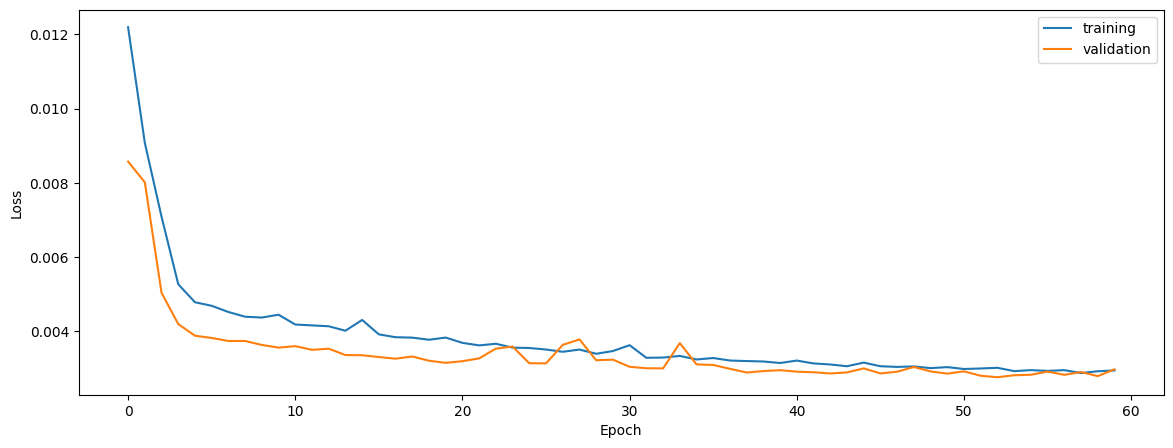

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.8295618177135649
0.8245501621694069
0.8184657342619548


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.8270212910345989
0.8290382440426383
0.823347554431279


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.8266405776677579
0.8238551344371384
0.824225069671077


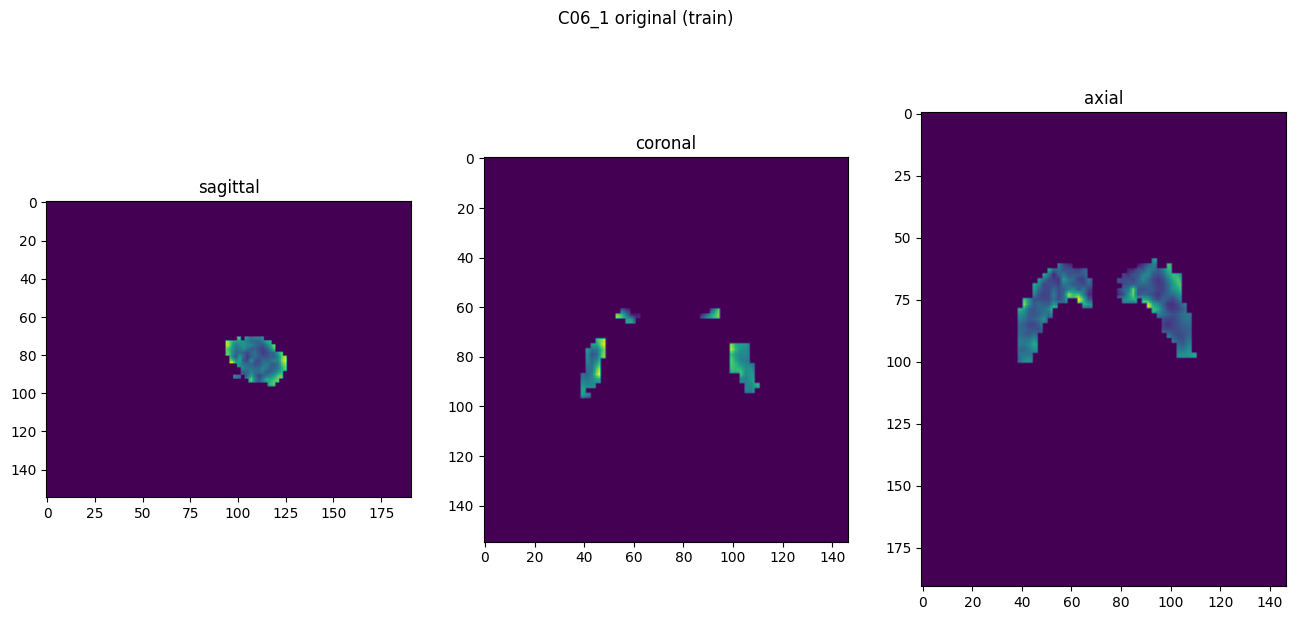

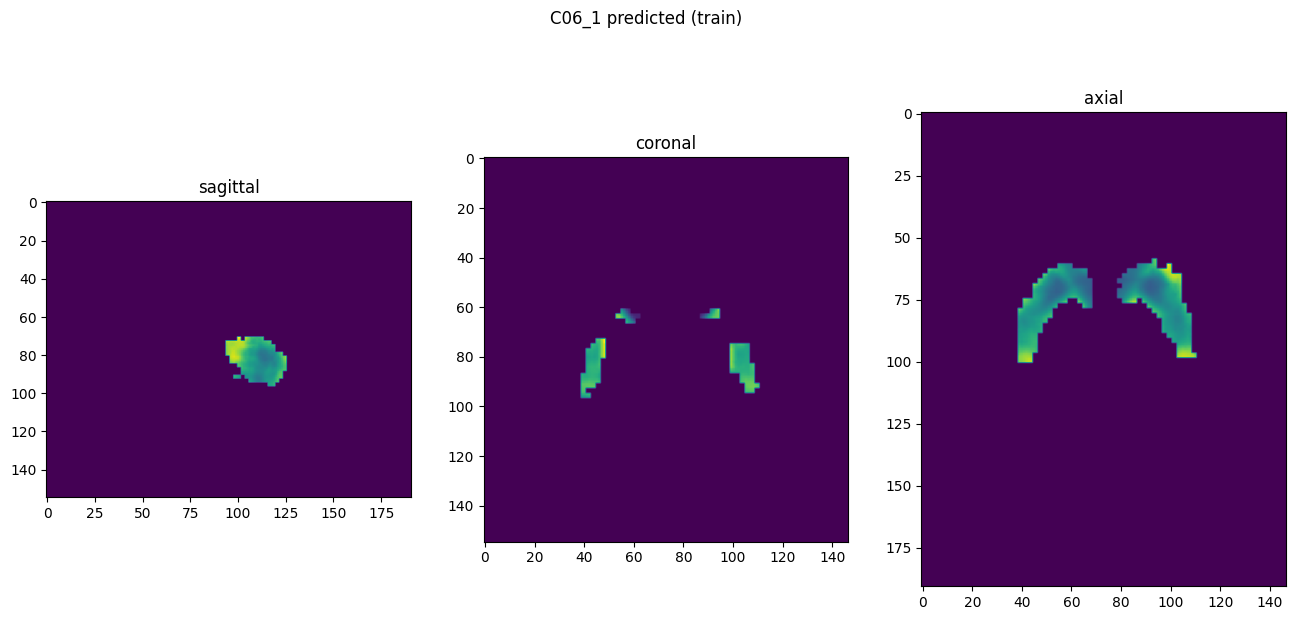

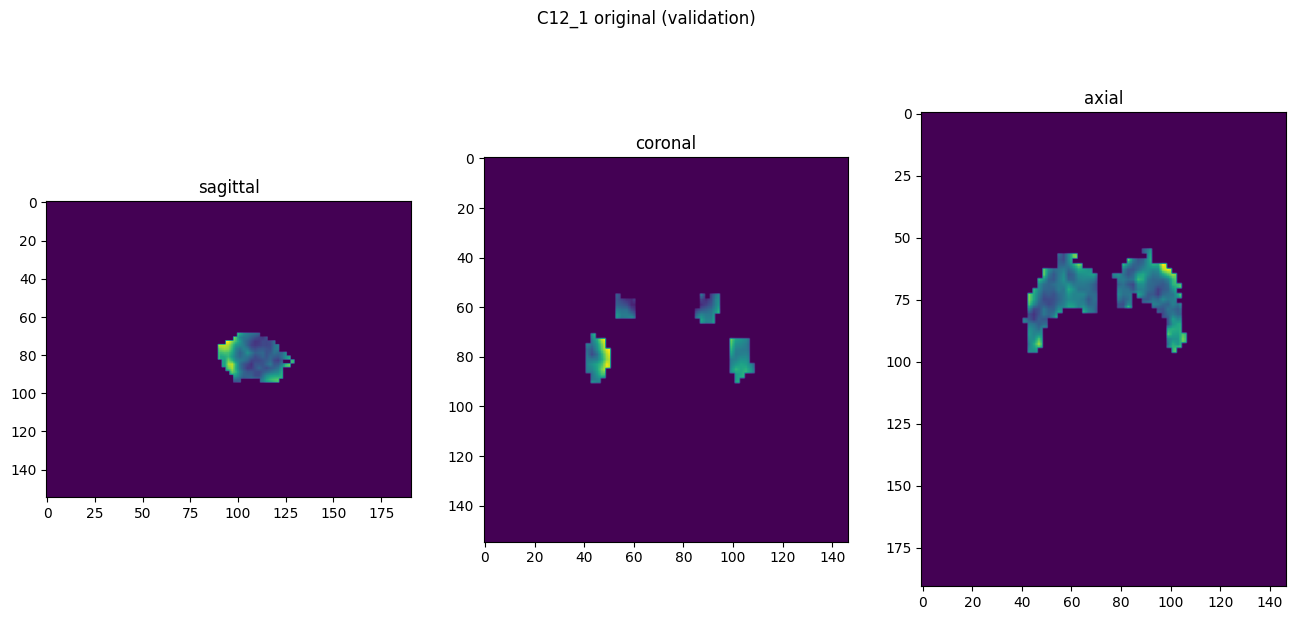

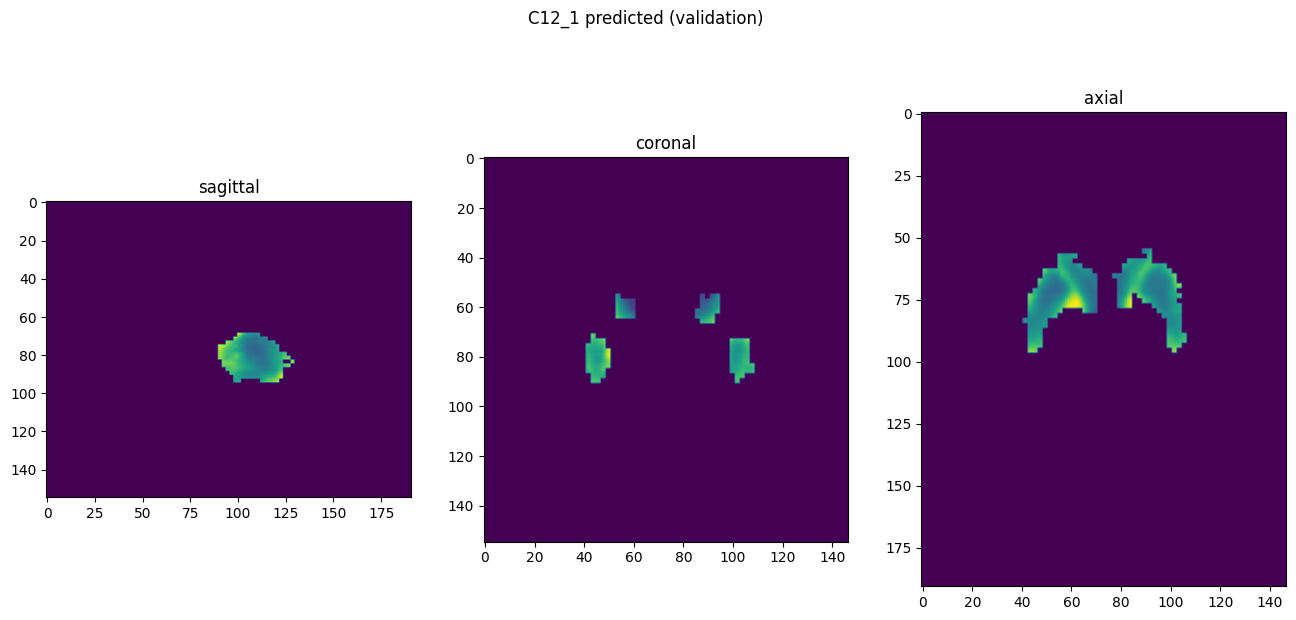

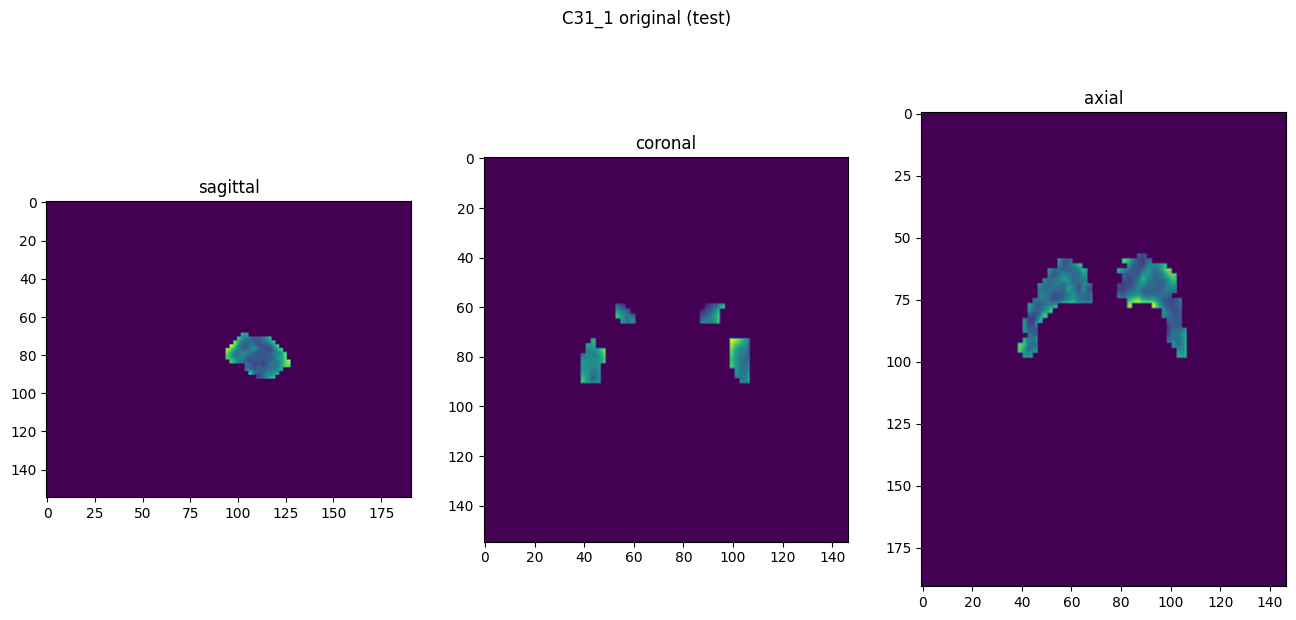

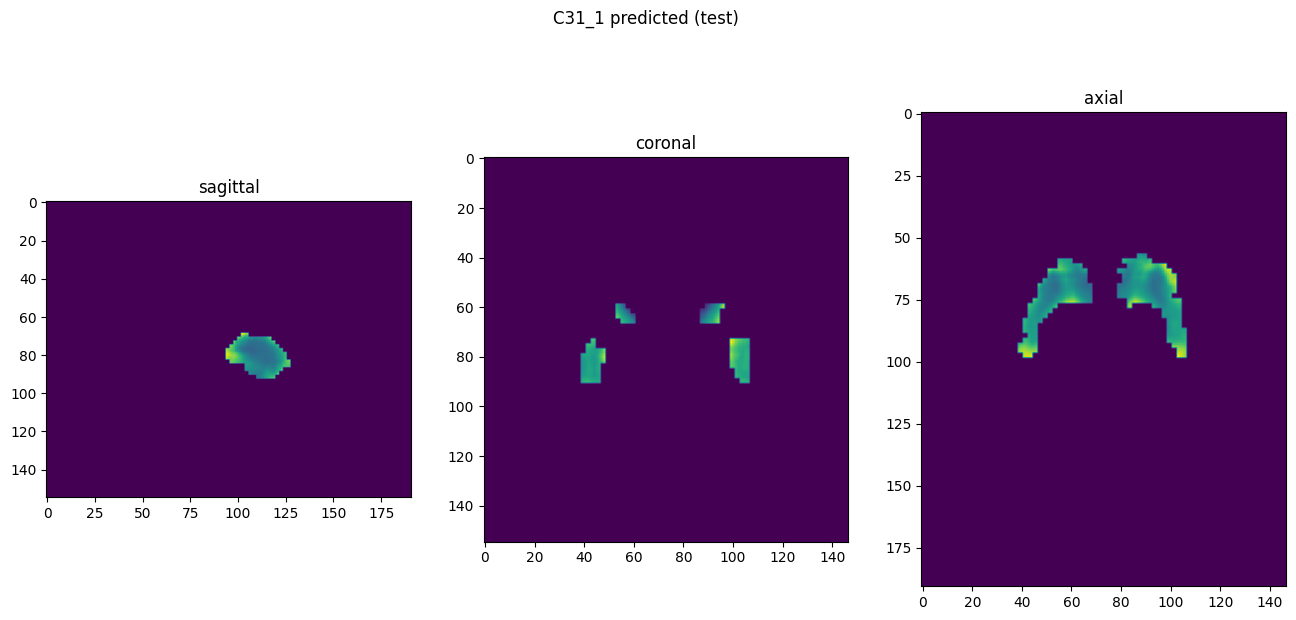

In [10]:
showResults(model, gen, threshold=None, background=False)